In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline


# Convex Optimization

+ The cost function, fitness, or empirical risk is usually well-defined
+ + Error of a neural network on training data
+ + The fitness of a genotype
+ + The stability of a folded protein configuration
+ + Whether a given configuration is a true ground state or metastable

<br>

+ If we can query every point in input space, we can guarantee that we've found a global minimum
+ If the function is convex, we can step towards minima in a principled way

+ Non-convex, we either have to perform many queries, or have external information that we can use to refine our search. Non-convex optimization over binary variables is NP-hard
+ + That means it's in the same difficulty class as [Donkey Kong Country](https://arxiv.org/abs/1203.1895)


Text(0.5, 1.0, 'A non-convex optimization problem')

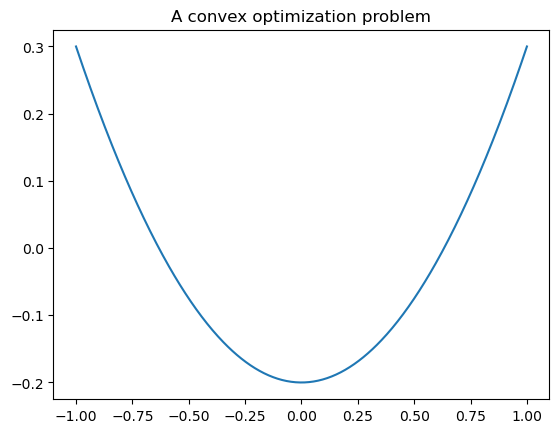

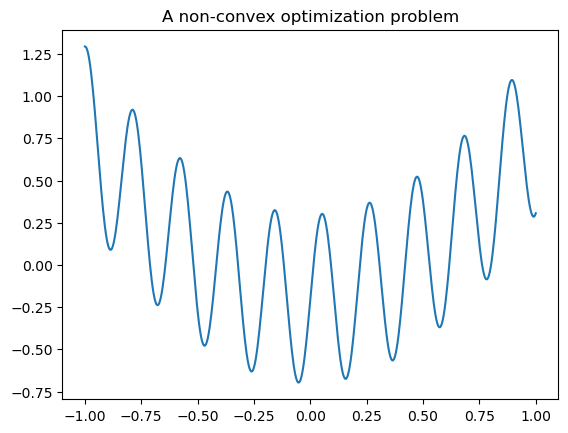

In [34]:
xx = np.linspace(-1, 1, 500)

f_con = lambda x: 0.5 * x**2 - 0.2
f_noncon = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2

plt.figure()
plt.plot(xx, f_con(xx))
plt.title('A convex optimization problem')

plt.figure()
plt.plot(xx, f_noncon(xx))
plt.title('A non-convex optimization problem')



We've already seen an example: in the Conjugate Gradient Method, we took steps towards a fixed point that represented the least-squares solution to the unconstrained linear problem


# One dimensional optimization: fixed point methods and rootfinding

+ I'm given some function $f(x)$, and I want to calculate the global minimum (convex) or the nearest local minimum to a start point (for nonconvex)
+ We use our standard approach of finding the nearest point at which $f' = 0$, reducing the calculation to rootfinding



# Gradient descent

+ A first-order method
+ a basic hill-climbing algorithm
+ Requires an estimate of the derivative of the loss function. Minimizing the loss is equivalent to finding the root of its derivative

Starting from an arbitrary point on the landscape, take steps along the direction of steepest descent

$$
x \leftarrow x - \eta \dfrac{df}{dx}
$$

The learning rate is a "hyperparameter" that we choose based on problem knowledge. Too large, and we can get stuck in oscillating solutions around the optima. Too small, and the system takes a long time to converge.

Optimal value: -0.19999999995313303


Text(0, 0.5, 'x')

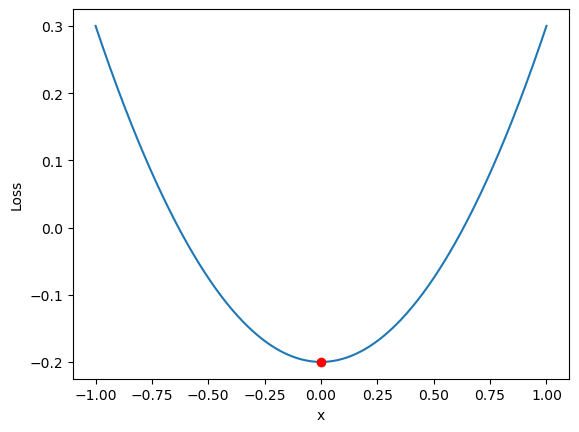

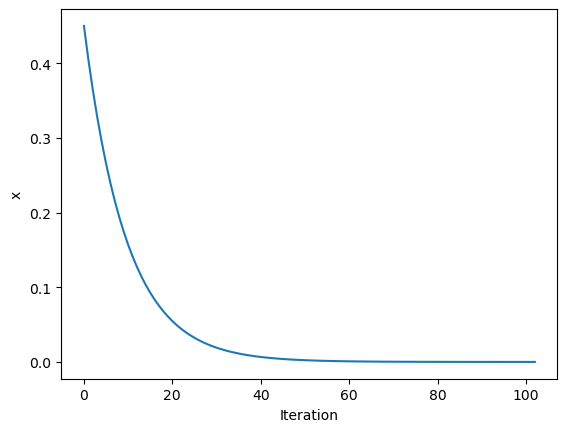

In [90]:
class GradientDescentOptimizer:

    def __init__(self, learning_rate=0.1, max_iter=1000, tolerance=1e-6, store_history=False):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.store_history = store_history
        if self.store_history:
            self.history = list()

    def optimize(self, df, x0):
        x = x0
        for i in range(self.max_iter):
            x_new = x - self.learning_rate * df(x)
            if np.linalg.norm(x_new - x) < self.tolerance:
                break
            x = x_new

            if self.store_history:
                self.history.append(x_new)

        return x

loss = lambda x: 0.5 * x**2 - 0.2
loss_grad = lambda x: x

optimizer = GradientDescentOptimizer(store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.5)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

### Modifying gradient descent for non-convex functions

We can add *momentum* to the optimizer, so that it keeps a memory of past timesteps and bearings

$$
v \leftarrow \eta \dfrac{df}{dx} + \alpha\, v
$$

$$
x \leftarrow x - v
$$

Text(0, 0.5, 'x')

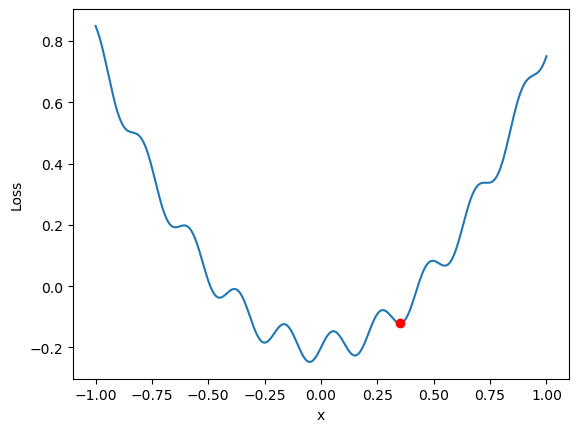

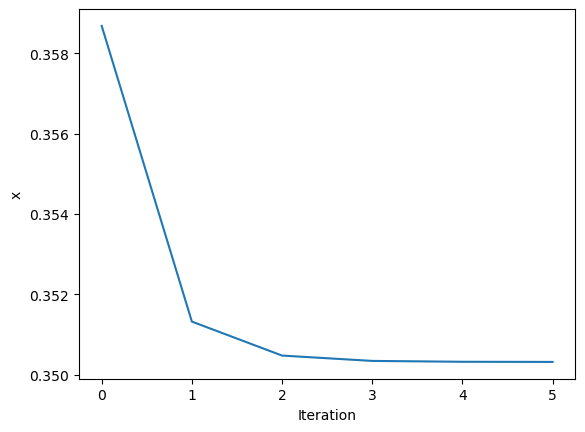

In [109]:
loss = lambda x: x**2 + 0.05 * np.sin(30 * x) - 0.2
loss_grad = lambda x: 2 * x + 0.05 * 30 * np.cos(30 * x)

## Solve optimization
optimizer = GradientDescentOptimizer(learning_rate=0.02, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.4)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')


Text(0, 0.5, 'x')

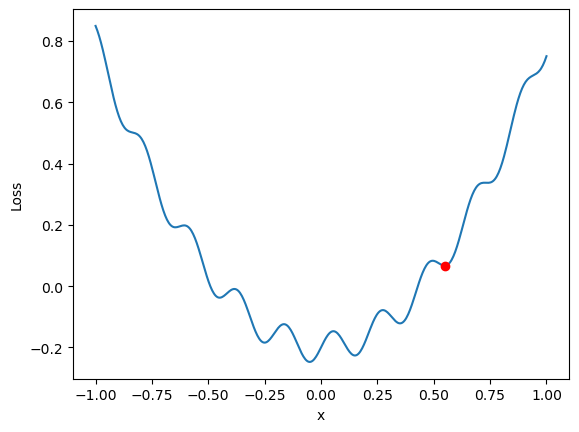

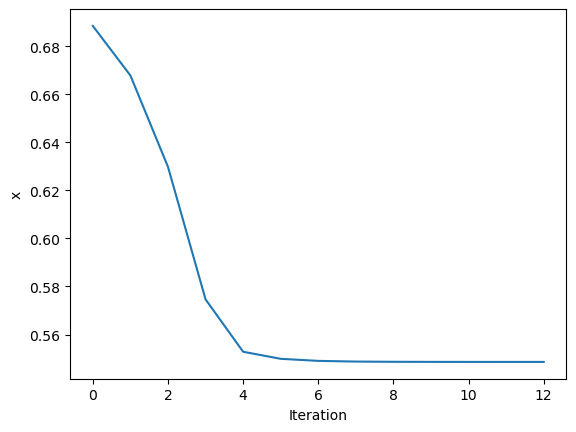

In [117]:
## Solve optimization
optimizer = GradientDescentOptimizer(learning_rate=0.02, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.7)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

Text(0, 0.5, 'x')

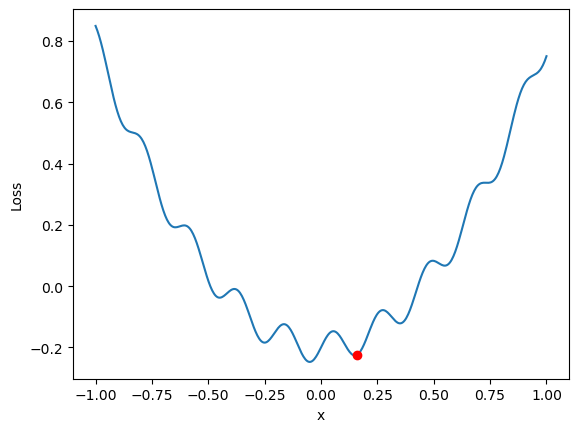

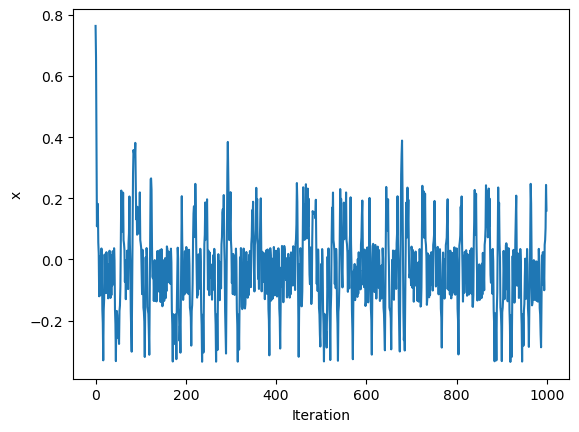

In [128]:
class GradientDescentMomentumOptimizer:
    
        def __init__(self, learning_rate=0.1, momentum=0.9, max_iter=1000, tolerance=1e-6, store_history=False):
            self.learning_rate = learning_rate
            self.momentum = momentum
            self.max_iter = max_iter
            self.tolerance = tolerance
            self.store_history = store_history
            if self.store_history:
                self.history = list()
    
        def optimize(self, df, x0):
            x = x0
            v = 0
            for i in range(self.max_iter):
                v = self.momentum * v + self.learning_rate * df(x)
                x_new = x - v
                if np.linalg.norm(x_new - x) < self.tolerance:
                    break
                x = x_new
    
                if self.store_history:
                    self.history.append(x_new)
    
            return x

## Solve optimization
optimizer = GradientDescentMomentumOptimizer(learning_rate=0.1, momentum=0.3, store_history=True)
x_opt = optimizer.optimize(loss_grad, 0.9)

## Plot loss
xx = np.linspace(-1, 1, 500)
plt.figure()
plt.plot(xx, loss(xx))
plt.plot(x_opt, loss(x_opt), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

## Second-order methods and Newton's method

Can we improve convergence using information about the local landscape geometry?

### Newton's method

Suppose that our initial guess is $x_k$. We perform a second-order Taylor expansion around the guess,
$$
{\displaystyle f(x_{k}+ h)\approx f(x_{k})+f'(x_{k})h +{\frac {1}{2}}f''(x_{k})h^{2}.}
$$
We want to minimize this approximated local function in $h$,
$$
{\displaystyle \displaystyle 0={\frac {\rm {d}}{{\rm {d}} h}}\left(f(x_{k})+f'(x_{k})h+{\frac {1}{2}}f''(x_{k})h^{2}\right)=f'(x_{k})+f''(x_{k})h,}
$$
Solving this equation, we arrive at 
$$
h^* = -{\frac {f'(x_{k})}{f''(x_{k})}},
$$

Having optimized the approximant, we now update the position of $x$,
$$
x_{k+1} = x_{k} + h^* = x_{k} - {\frac {f'(x_{k})}{f''(x_{k})}}.
$$

Basically, in a single timestep Newton's method we approximate the function locally as a parabola, and we then jump to the optimum of that parabolic approximant. Newton's method therefore consists of optimizing a global function by optimizing a series of local approximants.

<br><br>

### What if we don't know the derivatives of $f(x)$?

+ This is sometimes called the "secant" method
+ In many types of problems, we are best served by having a loss function with a differentiable form
+ As a fallback, we can use finite difference operators to approximate $f'$ and $f''$

$$
f'(x) \approx \dfrac{f(x + \Delta x / 2) - f(x - \Delta x / 2)}{\Delta x}
$$
$$
f''(x) \approx \dfrac{f(x + \Delta x) - 2 f(x) + f(x - \Delta x)}{\Delta x^2}
$$
where $\Delta x / x \ll 1$

Here we have used central finite differences, but we could also use forward finite differences
$$
f'(x) \approx \dfrac{f(x + \Delta x) - f(x)}{\Delta x}
$$
$$
f''(x) \approx \dfrac{f(x + 2 \Delta x) - 2 f(x + \Delta x) + f(x)}{\Delta x^2}
$$
Or, analogously, backwards finite differences.

There also exist [higher-order finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference), as well as multivariate generalizations. Notice how the coefficients of the first and second derivatives are Pascal's triangle.

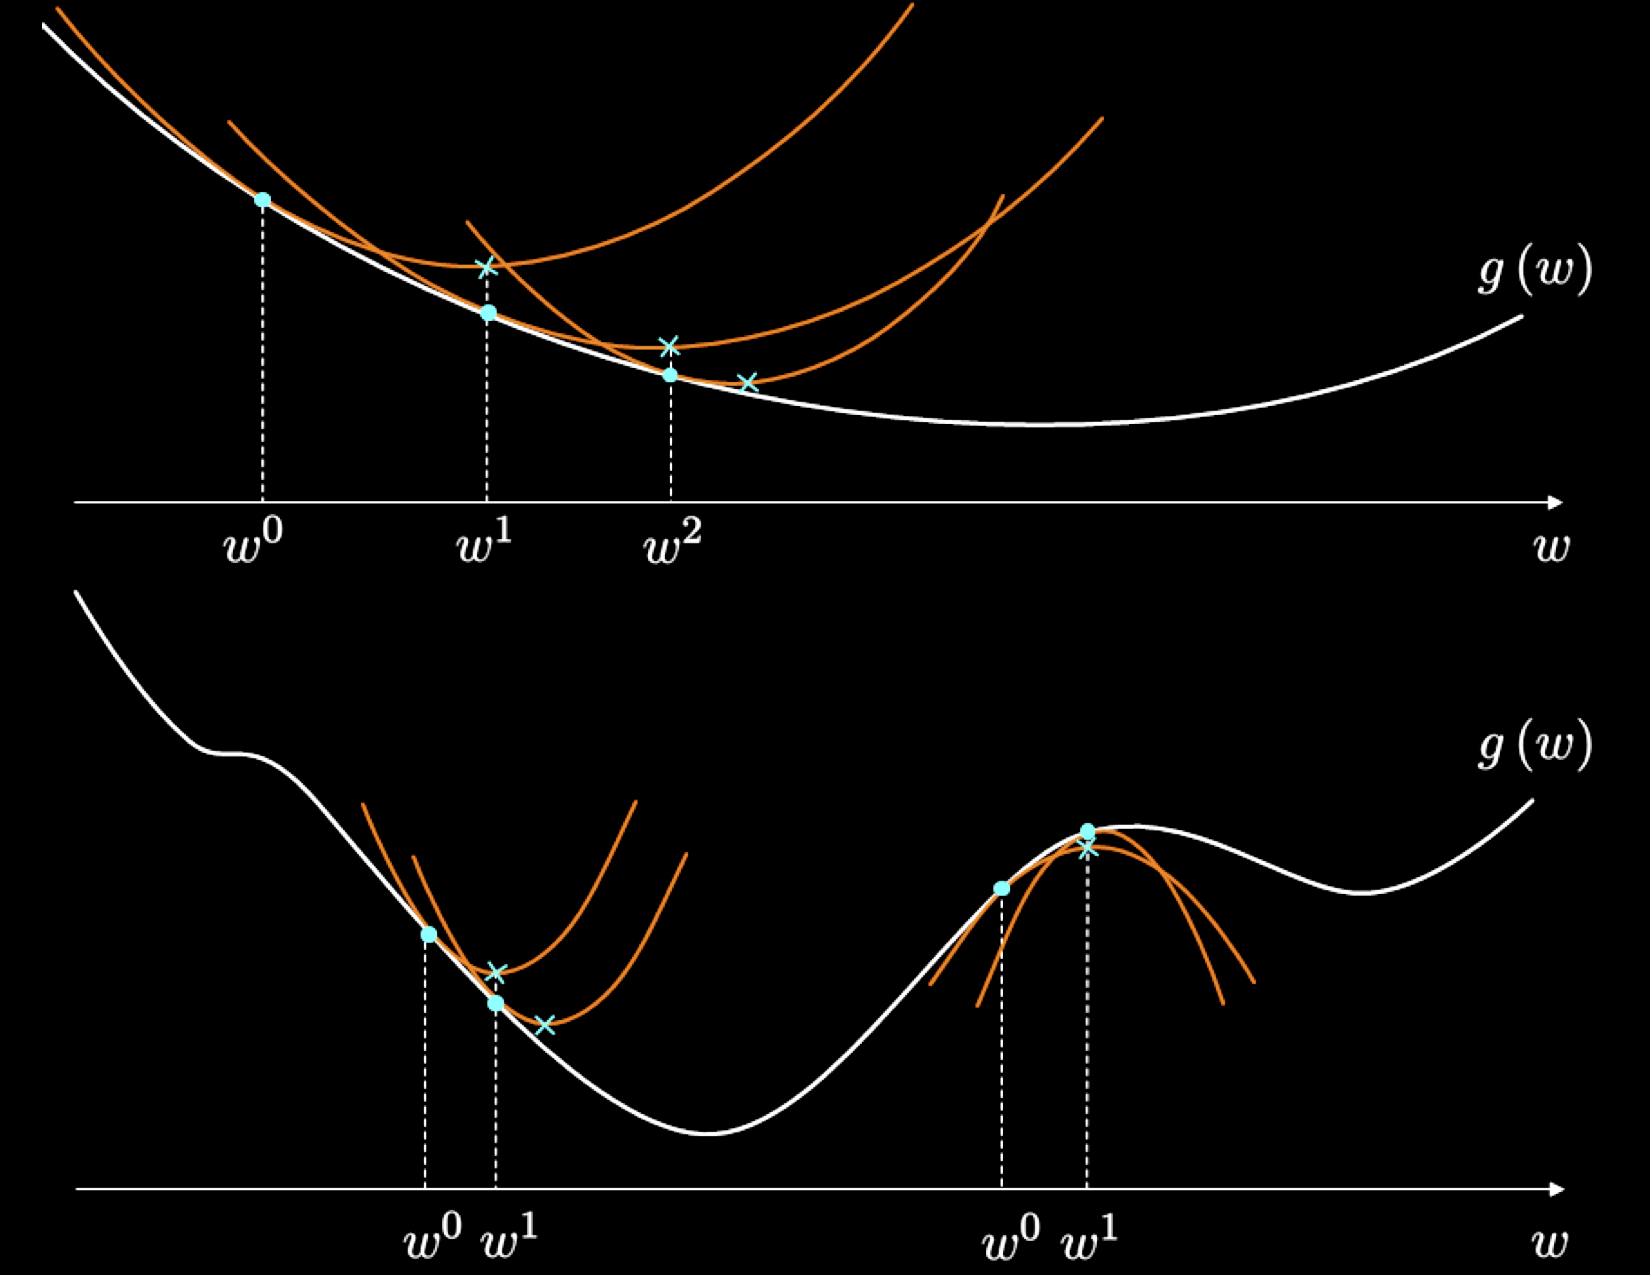

In [91]:
Image("../resources/newton.png", width=800)
# Source: https://jermwatt.github.io/machine_learning_refined/notes/4_Second_order_methods/4_4_Newtons.html

Text(0, 0.5, 'Loss')

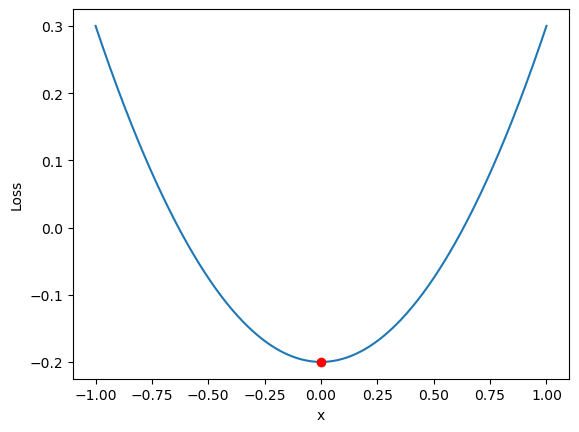

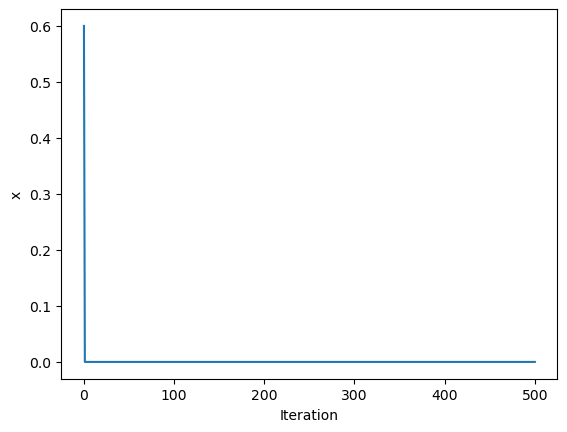

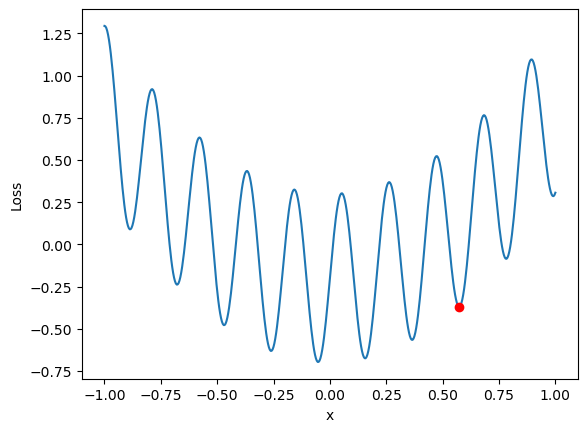

In [136]:
def finite_difference(f, x, dx=1e-5, order=1):
    """
    Compute the derivative of a function using finite differences

    Args:
        f: The function to differentiate
        x: The point at which to differentiate
        dx: The step size
        order: The order of the derivative to compute
    """
    if order == 1:
        return (f(x + dx / 2) - f(x - dx / 2)) / dx
    elif order == 2:
        return (f(x + dx) - 2 * f(x) + f(x - dx)) / dx**2
    else:
        raise ValueError('Only first and second order derivatives are supported')

class NewtonOptimizer:
    """
    A simple implementation of Newton's method for finding the optima of a function

    Parameters:
        tolerance (float): The tolerance for the stopping criterion
        max_iterations (int): The maximum number of iterations to perform
        store_history (bool): Whether to store the history of the optimization
    """
    def __init__(self, tolerance=1e-6, max_iterations=1000, store_history=False):
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.store_history = store_history
        if store_history:
            self.history = list()

    def optimize(self, f, x0, df=None, max_iter=500):

        x = x0

        if self.store_history:  self.history.append(np.copy(x))
        for _ in range(max_iter):

            # Approximate the derivatives
            fd = finite_difference(f, x, order = 1)
            fdd = finite_difference(f, x, order = 2)
            
            ## Stop early if the local concavity is zero
            if np.abs(fdd) < self.tolerance:
                break
            x = x - fd / fdd

            if self.store_history: self.history.append(np.copy(x))
        return x


## Convex function
loss = lambda x: 0.5 * x**2 - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.6)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

plt.figure()
plt.plot(optimizer.history)
plt.xlabel('Iteration')
plt.ylabel('x')

## Non-convex function
loss = lambda x :  x**2 + 0.5 * np.sin(30 * x) - 0.2
optimizer = NewtonOptimizer(store_history=True)
xstar = optimizer.optimize(loss, 0.6)

plt.figure()
plt.plot(xx, loss(xx))
plt.plot(xstar, loss(xstar), 'ro')
plt.xlabel('x')
plt.ylabel("Loss")

#### Interpreting the Newton optimizer

We can think of the Newton optimizer as a *second order method*. The update rule for $x$ was

$$
x \leftarrow x - {\frac{f'}{f''}}.
$$

The numerator of the update is just the local gradient step: we take a step in the direction of descent, at a rate proportional to the slope along that direction. The denominator we can interpret as an "adaptive learning rate": we take larger steps as the local landscape gets flatter, and smaller steps in very convex areas.

# Gradient descent in higher dimensions

# Newton's method in higher dimensions


